<a href="https://colab.research.google.com/github/asgharlaib/Project_v1/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#reading the dataset
full_df = pd.read_csv("/content/drive/MyDrive/LCL-June2015v2_134.csv")
full_df.head(n=10)

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC005555,Std,2012-06-15 03:30:00.0000000,0.118
1,MAC005555,Std,2012-06-15 04:00:00.0000000,0.078
2,MAC005555,Std,2012-06-15 04:30:00.0000000,0.091
3,MAC005555,Std,2012-06-15 05:00:00.0000000,0.068
4,MAC005555,Std,2012-06-15 05:30:00.0000000,0.092
5,MAC005555,Std,2012-06-15 06:00:00.0000000,0.194
6,MAC005555,Std,2012-06-15 06:30:00.0000000,0.091
7,MAC005555,Std,2012-06-15 07:00:00.0000000,0.069
8,MAC005555,Std,2012-06-15 07:30:00.0000000,0.088
9,MAC005555,Std,2012-06-15 08:00:00.0000000,0.087


In [4]:
#Making copy of origonal dataset
full_df_copy = full_df.copy()

In [5]:
#Looking for columns' datatypes
print(f"full_df columns datatypes: {full_df.dtypes} \n")

full_df columns datatypes: LCLid                      object
stdorToU                   object
DateTime                   object
KWH/hh (per half hour)     object
dtype: object 



In [7]:
# Convert the 'DateTime' column to datetime type
full_df['DateTime'] = pd.to_datetime(full_df['DateTime'])

# Extract the date and time into separate columns
full_df['Date'] = full_df['DateTime'].dt.date
full_df['Time'] = full_df['DateTime'].dt.time

# Display the first few rows to verify
print(full_df.head())

       LCLid stdorToU            DateTime KWH/hh (per half hour)         Date  \
0  MAC005555      Std 2012-06-15 03:30:00                  0.118   2012-06-15   
1  MAC005555      Std 2012-06-15 04:00:00                  0.078   2012-06-15   
2  MAC005555      Std 2012-06-15 04:30:00                  0.091   2012-06-15   
3  MAC005555      Std 2012-06-15 05:00:00                  0.068   2012-06-15   
4  MAC005555      Std 2012-06-15 05:30:00                  0.092   2012-06-15   

       Time  
0  03:30:00  
1  04:00:00  
2  04:30:00  
3  05:00:00  
4  05:30:00  


In [8]:
#Setting DateTiem as index
full_df.set_index('DateTime', inplace=True)

In [9]:
#Converting consumption column to numeric datatype
full_df['KWH/hh (per half hour) '] = pd.to_numeric(full_df['KWH/hh (per half hour) '], errors='coerce')
full_df.columns

Index(['LCLid', 'stdorToU', 'KWH/hh (per half hour) ', 'Date', 'Time'], dtype='object')

In [10]:
#Pre-processing for creating daily dataframe
full_df_daily = full_df.groupby(['Date', 'stdorToU', 'LCLid']).agg({'KWH/hh (per half hour) ': 'mean'}).reset_index()
full_df_daily.head(15)

,Date,stdorToU,LCLid,KWH/hh (per half hour)
0,2011-11-23,ToU,MAC000146,0.187300
1,2011-11-24,ToU,MAC000146,0.178417
2,2011-11-25,ToU,MAC000146,0.140479
3,2011-11-26,ToU,MAC000146,0.125604
4,2011-11-27,ToU,MAC000146,0.119583
5,2011-11-28,ToU,MAC000146,0.127000
6,2011-11-29,ToU,MAC000146,0.148354
7,2011-11-30,ToU,MAC000146,0.137750
8,2011-12-01,ToU,MAC000146,0.125042
9,2011-12-02,ToU,MAC000146,0.110604


In [11]:
##Descriptive Analysis
#Dataframe column names
print(f"Column names: {list(full_df_daily.columns)} \n")

#Dataframe shape
print(f"full_df_daily shape: {full_df_daily.shape} \n")

#Dataframe datatypes
print(f"full_df_daily columns datatypes: {full_df_daily.dtypes} \n")

#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

Column names: ['Date', 'stdorToU', 'LCLid', 'KWH/hh (per half hour) '] 

full_df_daily shape: (20876, 4) 

full_df_daily columns datatypes: Date                        object
stdorToU                    object
LCLid                       object
KWH/hh (per half hour)     float64
dtype: object 

missing values: Date                       0
stdorToU                   0
LCLid                      0
KWH/hh (per half hour)     5
dtype: int64 



In [12]:
#Locating nan indices
nan_indices = full_df_daily[full_df_daily['KWH/hh (per half hour) '].isnull()].index
print(nan_indices)

Index([9038, 9039, 9040, 9041, 9044], dtype='int64')


In [13]:
#Dealing with nan values
full_df_daily['KWH/hh (per half hour) '].fillna(full_df_daily['KWH/hh (per half hour) '].mean(skipna=True), inplace=True)
full_df_daily.head(15)

,Date,stdorToU,LCLid,KWH/hh (per half hour)
0,2011-11-23,Std,MAC000145,0.298400
1,2011-11-23,Std,MAC000148,0.045821
2,2011-11-23,Std,MAC000149,0.081679
3,2011-11-23,Std,MAC000150,0.330500
4,2011-11-23,Std,MAC000151,0.125885
5,2011-11-23,Std,MAC000152,0.248708
6,2011-11-23,Std,MAC000153,0.904250
7,2011-11-23,Std,MAC000154,0.252087
8,2011-11-23,Std,MAC000155,0.421864
9,2011-11-23,Std,MAC000156,0.296500


In [13]:
#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

missing values: Date                       0
stdorToU                   0
LCLid                      0
KWH/hh (per half hour)     5
dtype: int64 



In [14]:
##Descriptive Statistics
full_df_daily.describe()

,KWH/hh (per half hour)
count,20871.000000
mean,0.217520
std,0.139722
min,0.000000
25%,0.112417
50%,0.179479
75%,0.291698
max,1.391292


Text(0.5, 1.0, 'Standard vs Dynamic Time of Use Distribution')

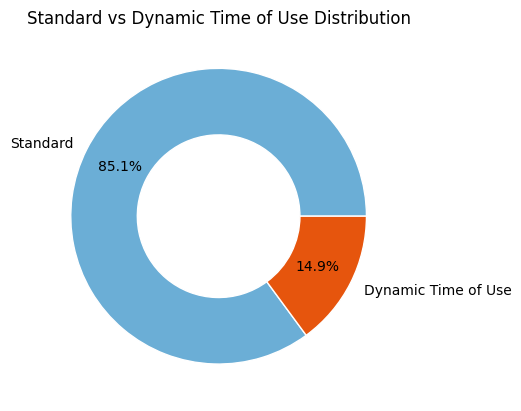

In [15]:
# EDA: Pie chart:
fig, ax = plt.subplots()
cmap = plt.colormaps["tab20c"]
outer_colors = cmap([1,4])
inner_colors = cmap([7,8,7,8])
size = 0.45
pctdist = 0.75

# Counts of households in std or ToU pricing Scheme
total_number = full_df_daily['stdorToU'].value_counts()

# Pie Chart to show distribution
ax.pie(
    np.array(total_number),
    autopct='%1.1f%%',
    pctdistance = pctdist,
    radius=1.0,
    colors=outer_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labels=['Standard','Dynamic Time of Use']
);
plt.title("Standard vs Dynamic Time of Use Distribution")


            Date stdorToU      LCLid  KWH/hh (per half hour) 
3005  2012-04-24      Std  MAC005561                 0.208625
3028  2012-04-25      Std  MAC005561                 0.047000
3293  2012-05-07      Std  MAC005562                 0.192149
3316  2012-05-08      Std  MAC005562                 0.169229
3339  2012-05-09      Std  MAC005562                 0.137375
         Date stdorToU      LCLid  KWH/hh (per half hour) 
0  2011-11-23      ToU  MAC000146                 0.187300
1  2011-11-24      ToU  MAC000146                 0.178417
2  2011-11-25      ToU  MAC000146                 0.140479
3  2011-11-26      ToU  MAC000146                 0.125604
4  2011-11-27      ToU  MAC000146                 0.119583


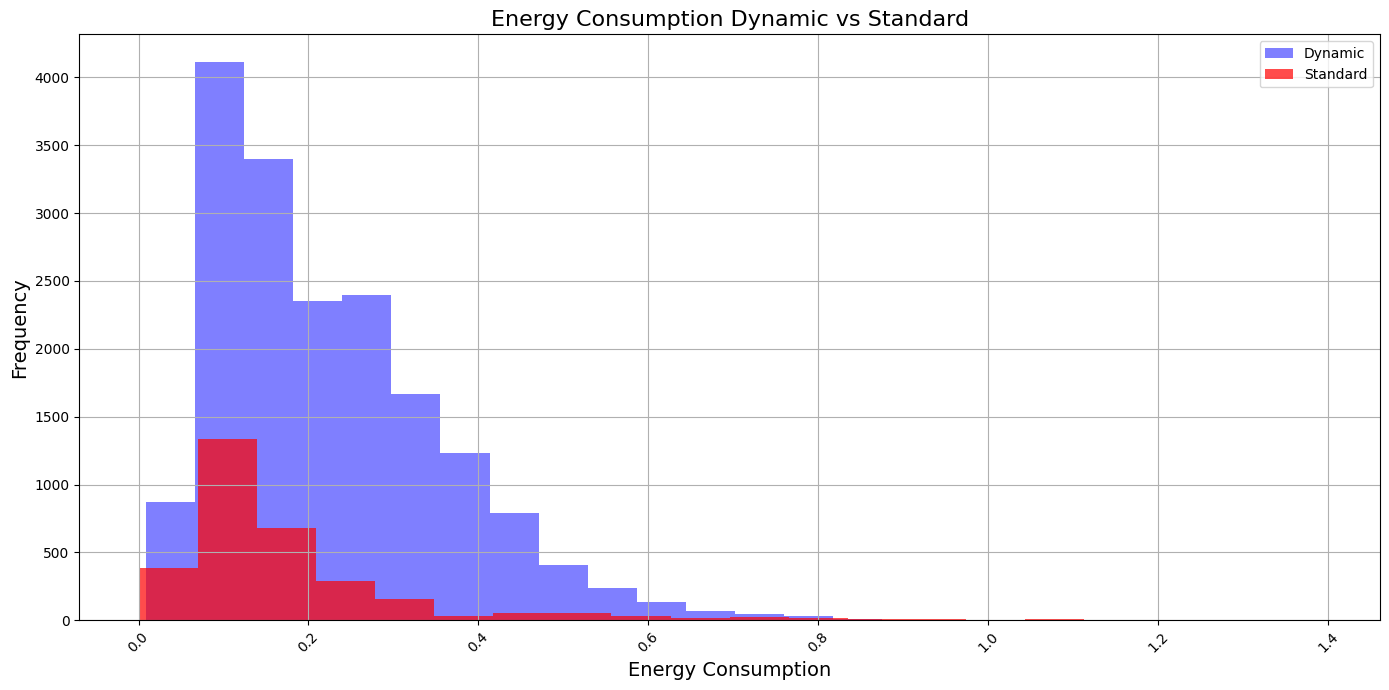

In [23]:
# Filter for dynamic and standard pricing
df_dynamic = full_df_daily[full_df_daily['stdorToU'] == 'ToU']
df_standard = full_df_daily[full_df_daily['stdorToU'] == 'Std']

print(df_standard.head())
print(df_dynamic.head())
# Plot the data
plt.figure(figsize=(14, 7))
plt.hist(df_dynamic['KWH/hh (per half hour) '], bins=20, alpha=0.5, color = 'b', label='Dynamic')
plt.hist(df_standard['KWH/hh (per half hour) '], bins=20, alpha=0.7, color = 'r', label='Standard')
#plt.plot(df_standard['Date'], df_standard['KWH/hh (per half hour) '], label='Standard')
#plt.plot(df_dynamic['Date'], df_dynamic['KWH/hh (per half hour) '], label='DToU')
# Formatting the plot
plt.title('Energy Consumption Dynamic vs Standard', fontsize=16)
plt.xlabel('Energy Consumption', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
quantile1 = full_df_daily['KWH/hh (per half hour) '].quantile(0.25)
quantile3 = full_df_daily['KWH/hh (per half hour) '].quantile(0.75)
Inter_quartile_range = quantile3 - quantile1
lower_bound = quantile1 - 1.5 * Inter_quartile_range
upper_bound = quantile3 + 1.5 * Inter_quartile_range

In [ ]:
full_df_daily['log_KWH'] = np.log(full_df_daily['KWH/hh (per half hour) '])

In [ ]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
plt.boxplot(full_df_daily['KWH/hh (per half hour) '])
plt.title('Boxplot of Energy Consumption Before Handling Outliers')
plt.ylabel('Energy Consumption')

plt.subplot(1,2,2)
plt.boxplot(full_df_daily['log_KWH'])
plt.title('Boxplot of Energy Consumption After Handling Outliers')
plt.ylabel('Energy Consumption')
plt.show()

In [80]:
# Function to preprocess the data for LSTM
def preprocess_data(df, time_step):
    target_feature = df['KWH/hh (per half hour) '].values
    target_feature = target_feature.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    target_fceature = scaler.fit_transform(target_feature)

    X, y = [], []
    for i in range(len(target_feature) - time_step - 1):
        X.append(target_feature[i:(i + time_step), 0])
        y.append(target_feature[i + time_step, 0])
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [81]:
# Preprocess the data
time_step = 8  # number of previous timesteps to use for prediction
X_dynamic, y_dynamic, scaler_dynamic = preprocess_data(df_dynamic, time_step)
X_standard, y_standard, scaler_standard = preprocess_data(df_standard, time_step)

# Split the data into training and testing sets
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_standard, y_standard, test_size=0.2, random_state=42)

In [76]:
# Build LSTM model
def build_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


In [77]:
# Train LSTM model
def train_model(X_train, y_train, X_val, y_val, input_shape, epochs=20, batch_size=32):
    print(f"Training model with input shape: {input_shape}")
    model = build_lstm_model(input_shape=input_shape)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)
    return model, history

In [92]:
# Evaluate LSTM model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

In [82]:
# Preprocess data
time_step = 8
X_dynamic, y_dynamic, scaler_dynamic = preprocess_data(df_dynamic, time_step)
X_standard, y_standard, scaler_standard = preprocess_data(df_standard, time_step)

# Split data into training and testing sets
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_standard, y_standard, test_size=0.2, random_state=42)

In [83]:
# Print data shapes for debugging
print(f"X_train_dyn shape: {X_train_dyn.shape}")
print(f"X_test_dyn shape: {X_test_dyn.shape}")
print(f"y_train_dyn shape: {y_train_dyn.shape}")
print(f"y_test_dyn shape: {y_test_dyn.shape}")

print(f"X_train_std shape: {X_train_std.shape}")
print(f"X_test_std shape: {X_test_std.shape}")
print(f"y_train_std shape: {y_train_std.shape}")
print(f"y_test_std shape: {y_test_std.shape}")

# Ensure y_train and y_test have consistent shapes
y_train_dyn = y_train_dyn.reshape(-1, 1)
y_test_dyn = y_test_dyn.reshape(-1, 1)
y_train_std = y_train_std.reshape(-1, 1)
y_test_std = y_test_std.reshape(-1, 1)

# Print reshaped target data shapes
print(f"After reshaping: y_train_dyn shape: {y_train_dyn.shape}, y_test_dyn shape: {y_test_dyn.shape}")
print(f"After reshaping: y_train_std shape: {y_train_std.shape}, y_test_std shape: {y_test_std.shape}")

# Define input shapes
input_shape_dyn = (X_train_dyn.shape[1], X_train_dyn.shape[2])
input_shape_std = (X_train_std.shape[1], X_train_std.shape[2])


X_train_dyn shape: (14204, 8, 1)
X_test_dyn shape: (3551, 8, 1)
y_train_dyn shape: (14204,)
y_test_dyn shape: (3551,)
X_train_std shape: (2482, 8, 1)
X_test_std shape: (621, 8, 1)
y_train_std shape: (2482,)
y_test_std shape: (621,)
After reshaping: y_train_dyn shape: (14204, 1), y_test_dyn shape: (3551, 1)
After reshaping: y_train_std shape: (2482, 1), y_test_std shape: (621, 1)


In [84]:
# Train LSTM models
model_dyn, history_dyn = train_model(X_train_dyn, y_train_dyn, X_test_dyn, y_test_dyn, input_shape_dyn)
model_std, history_std = train_model(X_train_std, y_train_std, X_test_std, y_test_std, input_shape_std)

Training model with input shape: (8, 1)
Building LSTM model with input shape: (8, 1)
Epoch 1/20
444/444 [==============================] - 6s 7ms/step - loss: 0.0186 - val_loss: 0.0188
Epoch 2/20
444/444 [==============================] - 2s 6ms/step - loss: 0.0180 - val_loss: 0.0186
Epoch 3/20
444/444 [==============================] - 3s 6ms/step - loss: 0.0178 - val_loss: 0.0187
Epoch 4/20
444/444 [==============================] - 2s 6ms/step - loss: 0.0178 - val_loss: 0.0191
Epoch 5/20
444/444 [==============================] - 2s 6ms/step - loss: 0.0168 - val_loss: 0.0172
Epoch 6/20
444/444 [==============================] - 2s 6ms/step - loss: 0.0162 - val_loss: 0.0168
Epoch 7/20
444/444 [==============================] - 2s 5ms/step - loss: 0.0161 - val_loss: 0.0171
Epoch 8/20
444/444 [==============================] - 3s 6ms/step - loss: 0.0159 - val_loss: 0.0167
Epoch 9/20
444/444 [==============================] - 2s 5ms/step - loss: 0.0158 - val_loss: 0.0164
Epoch 10/20
444

In [91]:
# Check for NaN values in the test sets
print("Checking for NaN values in X_test_std and y_test_std:")
print(f"NaN values in X_test_std: {np.isnan(X_test_std).sum()}")
print(f"NaN values in y_test_std: {np.isnan(y_test_std).sum()}")

# Check for NaN values in the test sets
print("Checking for NaN values in X_test_dyn and y_test_dyn:")
print(f"NaN values in X_test_dyn: {np.isnan(X_test_dyn).sum()}")
print(f"NaN values in y_test_dyn: {np.isnan(y_test_dyn).sum()}")

Checking for NaN values in X_test_std and y_test_std:
NaN values in X_test_std: 0
NaN values in y_test_std: 0
Checking for NaN values in X_test_dyn and y_test_dyn:
NaN values in X_test_dyn: 0
NaN values in y_test_dyn: 0
